In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1. Get data

In [2]:
url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/all-agents/daily/20181231/20191020"
headers = {"accept": "application/json"}
r = requests.get(url, headers=headers)

In [3]:
df = pd.DataFrame(r.json()["items"])

In [4]:
df.head()

,project,access,agent,granularity,timestamp,views
0,en.wikipedia,all-access,all-agents,daily,2018123100,302878752
1,en.wikipedia,all-access,all-agents,daily,2019010100,312601914
2,en.wikipedia,all-access,all-agents,daily,2019010200,326949126
3,en.wikipedia,all-access,all-agents,daily,2019010300,321689932
4,en.wikipedia,all-access,all-agents,daily,2019010400,315004706


In [5]:
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y%m%d00")

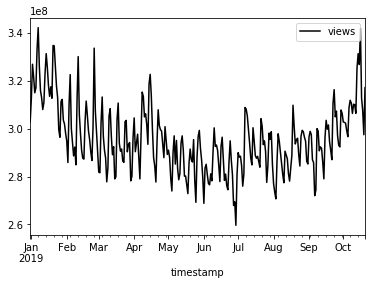

In [6]:
df[["timestamp", "views"]].set_index("timestamp").plot(color="black");

In [7]:
df = (df[["timestamp", "views"]]
      .rename(columns={"timestamp": "date_id",
                       "views": "pageviews"})
      .assign(page_name="landing_page"))

In [8]:
df = df[["date_id", "page_name", "pageviews"]]

In [9]:
df.to_csv("data/daily_pageviews.csv", index=False)

# 2. Load data

In [10]:
df = pd.read_csv("data/daily_pageviews.csv")

In [11]:
df.dtypes

date_id      object
page_name    object
pageviews     int64
dtype: object

In [12]:
df["date_id"] = pd.to_datetime(df["date_id"])

# 3. Plot daily pageviews

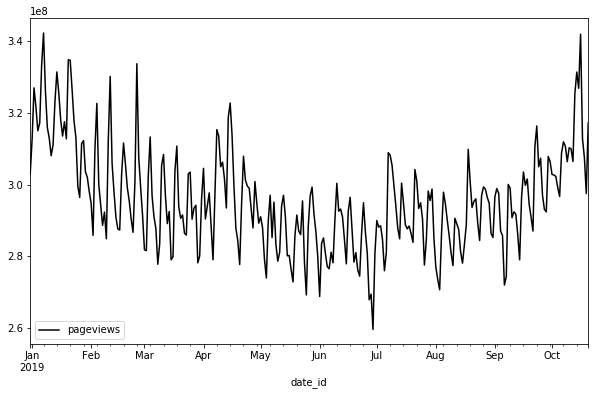

In [13]:
fig, ax = plt.subplots(figsize=(10,6))

(df[["date_id", "pageviews"]]
 .set_index("date_id")
 .plot(color="black",
       ax=ax));

---
# 4. Plot weekly pageviews

### Truncate timestamp to first day of week

In [14]:
ts = df[["date_id"]].copy()

In [15]:
ts = ts.assign(dayofweek=pd.to_timedelta(ts["date_id"].dt.dayofweek, unit="D"))

In [16]:
ts["dayofweek"]

0     0 days
1     1 days
2     2 days
3     3 days
4     4 days
       ...  
289   2 days
290   3 days
291   4 days
292   5 days
293   6 days
Name: dayofweek, Length: 294, dtype: timedelta64[ns]

In [17]:
ts = ts.assign(week_id=ts["date_id"] - ts["dayofweek"])

In [18]:
df = df.assign(week_id=ts["week_id"])

---

In [19]:
df_weekly = (df[["week_id", "pageviews"]]
             .groupby("week_id")
             .agg({"pageviews": "sum"}))

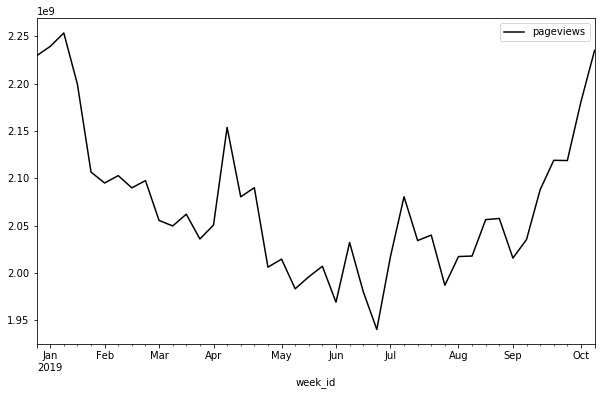

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

df_weekly.plot(color="black",
               ax=ax);

Draw vertical lines in red to highlight the campaign range

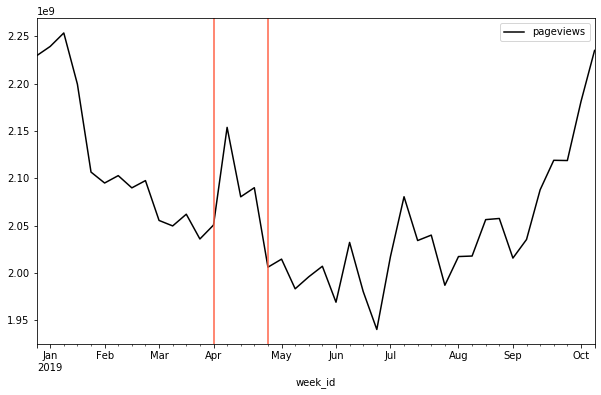

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

df_weekly.plot(color="black",
               ax=ax)

ax.axvline("2019-04-01", c="tomato");
ax.axvline("2019-04-29", c="tomato");

# 5. Compute fitted line

In [22]:
# Add time variable
df_weekly = (df_weekly
             .reset_index()
             .assign(t=np.arange(1,len(df_weekly)+1)))

In [23]:
# Add constant
df_weekly = df_weekly.assign(const=1)

In [24]:
y = df_weekly["pageviews"]
X = df_weekly[["const", "t"]]

lin_reg = sm.OLS(y, X)
results = lin_reg.fit()

In [25]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.829
Date:                Wed, 08 Apr 2020   Prob (F-statistic):             0.0574
Time:                        15:41:49   Log-Likelihood:                -820.07
No. Observations:                  42   AIC:                             1644.
Df Residuals:                      40   BIC:                             1648.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.112e+09   2.35e+07     89.803      0.000    2.06e+09    2.16e+09
t          -1.865e+06   9.53e+05     -1.957      0.057   -3.79e+06    6.13e+04
==============================================================================
Omnibus:                        6.177   Durbin-Watson:                   0.355
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.380
Skew:                           0.870   Prob(JB):                       0.0679
Kurtosis:                       3.213   Cond. No.                         50.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# add predictions
df_weekly = df_weekly.assign(predicted_pageviews=results.predict(X))

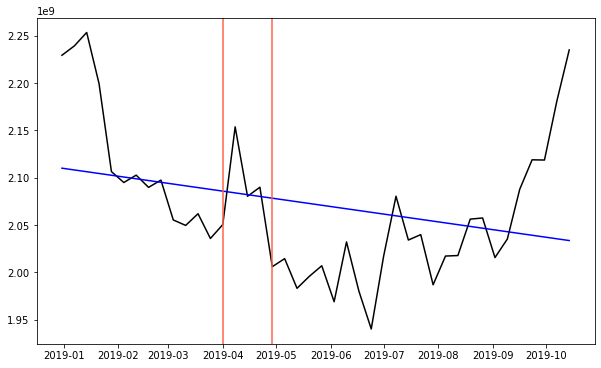

In [27]:
# plot fitted line
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df_weekly["week_id"],
        df_weekly["pageviews"],
        color="black");

ax.plot(df_weekly["week_id"],
        df_weekly["predicted_pageviews"],
        color="blue");

ax.axvline("2019-04-01", c="tomato");
ax.axvline("2019-04-29", c="tomato");

No good.

# 6. Fit quadratic line

In [28]:
df_weekly = df_weekly.assign(t2=df_weekly["t"]**2)

In [29]:
y = df_weekly["pageviews"]
X = df_weekly[["const", "t", "t2"]]
quad_reg = sm.OLS(y, X)
results_quad = quad_reg.fit()
results_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     56.43
Date:                Wed, 08 Apr 2020   Prob (F-statistic):           3.08e-12
Time:                        15:41:49   Log-Likelihood:                -793.45
No. Observations:                  42   AIC:                             1593.
Df Residuals:                      39   BIC:                             1598.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.261e+09   1.95e+07    115.709      0.000    2.22e+09     2.3e+09
t          -2.214e+07    2.1e+06    -10.567      0.000   -2.64e+07   -1.79e+07
t2          4.716e+05   4.73e+04      9.979      0.000    3.76e+05    5.67e+05
==============================================================================
Omnibus:                        7.152   Durbin-Watson:                   1.140
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                5.908
Skew:                           0.840   Prob(JB):                       0.0521
Kurtosis:                       3.745   Cond. No.                     2.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
df_weekly = df_weekly.assign(predicted_pageviews_quad=results_quad.predict(X))

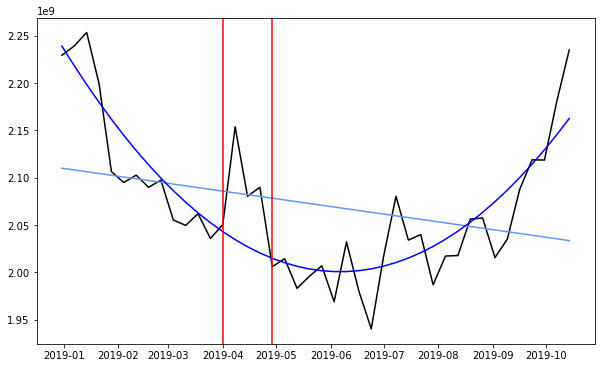

In [31]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df_weekly["week_id"],
        df_weekly["pageviews"],
        color="black");

ax.plot(df_weekly["week_id"],
        df_weekly["predicted_pageviews"],
        color="cornflowerblue");

ax.plot(df_weekly["week_id"],
        df_weekly["predicted_pageviews_quad"],
        color="blue");

ax.axvline("2019-04-01", c="r");
ax.axvline("2019-04-29", c="r");

Much better

# 7. Estimate impact of campaign on pageviews

In [32]:
# calculate weekly diff
df_weekly = df_weekly.assign(diff=df_weekly["pageviews"] - df_weekly["predicted_pageviews_quad"])

In [33]:
# calculate cumulative diff
additional_pageviews = df_weekly.loc[df_weekly["week_id"].between("2019-04-08", "2019-04-22"), "diff"].sum()

In [34]:
print(f"The campaign resulted in an estimated increase in pageviews of {int(additional_pageviews)} over 3 weeks")

The campaign resulted in an estimated increase in pageviews of 241857419 over 3 weeks


In [44]:
# calculate relative diff
predicted_pageviews = df_weekly.loc[df_weekly["week_id"].between("2019-04-08", "2019-04-22"), "pageviews"].sum()

In [45]:
print(f"The campaign resulted in an estimated increase in pageviews of ~{round((additional_pageviews / predicted_pageviews)*100, 2)}%")

The campaign resulted in an estimated increase in pageviews of ~3.82%


# 8. Recommendation

Additional data points:

On a weekly basis, on average:
- users view 17.3 pages
- the conversation rate for unique users is 1%
- the CLV value for a user is 48.9 EUR

Given that we spent 75,000 EUR for the marketing campaign, would you conclude that the campaign was successful?

### Analysis:

In [61]:
# set variable
pvpu = 17.3 # pageviews per user
cr = .001
margin = .1
clv = 48.9

In [54]:
# get relevant subset of df_weekly for analysis
analysis = (df_weekly
            .loc[df_weekly["week_id"].between("2019-04-08", "2019-04-22"),
                 ["week_id", "pageviews", "predicted_pageviews_quad", "diff"]])

In [55]:
analysis

,week_id,pageviews,predicted_pageviews_quad,diff
14,2019-04-08,2153783320,2.034676e+09,1.191070e+08
15,2019-04-15,2080427928,2.027152e+09,5.327569e+07
16,2019-04-22,2090046150,2.020571e+09,6.947473e+07


In [62]:
# calculate estimated conversions
analysis = analysis.assign(estimated_conversions=(analysis["pageviews"]/pvpu)*cr)
analysis

,week_id,pageviews,predicted_pageviews_quad,diff,estimated_conversions,estimated_conversions_predicted
14,2019-04-08,2153783320,2.034676e+09,1.191070e+08,124496.145665,1.176113e+06
15,2019-04-15,2080427928,2.027152e+09,5.327569e+07,120255.949595,1.171764e+06
16,2019-04-22,2090046150,2.020571e+09,6.947473e+07,120811.916185,1.167960e+06


In [63]:
# calculate estimated predicted conversions
analysis = analysis.assign(estimated_conversions_predicted=(analysis["predicted_pageviews_quad"]/pvpu)*cr)
analysis

,week_id,pageviews,predicted_pageviews_quad,diff,estimated_conversions,estimated_conversions_predicted
14,2019-04-08,2153783320,2.034676e+09,1.191070e+08,124496.145665,117611.347924
15,2019-04-15,2080427928,2.027152e+09,5.327569e+07,120255.949595,117176.430218
16,2019-04-22,2090046150,2.020571e+09,6.947473e+07,120811.916185,116796.035669


In [64]:
# compute estimated additional conversions due to campaign
additional_conversions = (analysis["estimated_conversions"] - analysis["estimated_conversions_predicted"]).sum()
additional_conversions

13980.197633517484

In [65]:
# generate estimated increase in revenue
print(f"The 3 week campaign resulted in an estimated increase in profit of {int(additional_conversions*margin*clv)} EUR")

The 3 week campaign resulted in an estimated increase in profit of 68363 EUR


Given we spent 75,000 EUR on this campaign, we did not observe a positive return on investment.